In [2]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings

import sys
sys.path.append('/glade/u/home/ivyglade/pdo')
import pdo_functions

import importlib
importlib.reload(pdo_functions)

import dask
from dask.diagnostics import ProgressBar
from dask.distributed import Client
dask.config.set({"array.slicing.split_large_chunks": False})
import time
import glob
import pandas as pd
import numba

import os

In [5]:
# Open CAPE data
cape_1940s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')['CAPE'][184*10:]
cape_1950s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1950s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19500101-19591231.nc')['CAPE'][184*10:]
cape_1960s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1960s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19600101-19691231.nc')['CAPE'][184*10:]
cape_1970s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1970s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19700101-19791231.nc')['CAPE'][184*10:]
cape_1980s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1980s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19800101-19891231.nc')['CAPE']
cape_1990s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/1990s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19900101-19991231.nc')['CAPE']
cape_2000s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/2000s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20000101-20091231.nc')['CAPE']
cape_2010s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/2010s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20100101-20191231.nc')['CAPE']
cape_2020s = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/ERA5_cape/ERA5_cape/2020s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20200101-20241130.nc')['CAPE']

In [6]:
# Subset the CONUS
cape_1940s_conus = cape_1940s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1950s_conus = cape_1950s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1960s_conus = cape_1960s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1970s_conus = cape_1970s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1980s_conus = cape_1980s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1990s_conus = cape_1990s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2000s_conus = cape_2000s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2010s_conus = cape_2010s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2020s_conus = cape_2020s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [7]:
# Concatenate time periods together
cape_conus = xr.concat([cape_1940s_conus, cape_1950s_conus, cape_1960s_conus, cape_1970s_conus, cape_1980s_conus, cape_1990s_conus, cape_2000s_conus,\
                        cape_2010s_conus, cape_2020s_conus], dim='time')

In [8]:
# Select MAM only and also resample by month
cape_conus_mam = cape_conus.sel(time=cape_conus.time.dt.month.isin([3, 4, 5])).resample(time='1M').mean().dropna(dim='time')

/scratch/ivyglade/miniconda3/envs/myenv/lib/python3.10/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [9]:
# Subsetting the southeast rectangle to compare detrend methods
cape_se_mam = cape_conus_mam.sel(longitude=slice(pdo_functions.convert_longitudes(-102), pdo_functions.convert_longitudes(-82))).sel(latitude=slice(38, 30))

In [10]:
# Open SST data
sst = xr.open_dataset('/hurrell-scratch/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [11]:
# standardize Nino3.4 values
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [13]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5]))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [12]:
def detrend_dim(da, dim, deg):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [14]:
lin_detrend = detrend_dim(cape_se_mam, 'time', 1)
poly_detrend = detrend_dim(cape_se_mam, 'time', 2)

In [15]:
# Remove the seasonal cycle
lin_detrend_no_climo = lin_detrend.groupby('time.month') - lin_detrend.groupby('time.month').mean()
poly_detrend_no_climo = poly_detrend.groupby('time.month') - poly_detrend.groupby('time.month').mean()
cape_se_mam_no_climo = cape_se_mam.groupby('time.month') - cape_se_mam.groupby('time.month').mean()

In [16]:
# Create weights, apply area weighting and take area average
weights = np.cos(np.deg2rad(lin_detrend_no_climo.latitude))

lin_detrend_no_climo_mean = lin_detrend_no_climo.weighted(weights).mean(dim=('latitude', 'longitude'))
poly_detrend_no_climo_mean = poly_detrend_no_climo.weighted(weights).mean(dim=('latitude', 'longitude'))
cape_se_mam_no_climo_mean = cape_se_mam_no_climo.weighted(weights).mean(dim=('latitude', 'longitude'))

# align time dimension
lin_detrend_no_climo_mean['time'] = pdo_1940_2024_mam['time']
poly_detrend_no_climo_mean['time'] = pdo_1940_2024_mam['time']
cape_se_mam_no_climo_mean['time'] = pdo_1940_2024_mam['time']

In [93]:
pdo_1940_2024_mam[66:120]

<xarray.DataArray 'pcs' (time: 54)> Size: 432B
array([-1.13787707, -0.98817799, -1.18452157, -0.16036893, -0.31636304,
       -1.12250911, -0.88289584, -1.41339861, -2.24236037, -0.52617655,
       -0.26831328, -0.64578875, -0.98352584, -0.28252921, -0.52697644,
       -0.83321671, -1.28758882, -1.80680491, -0.18052834, -0.86951243,
       -0.770205  , -0.9071978 , -0.7250929 , -0.69972838,  1.22728424,
        0.25457338, -0.76070533, -1.49636428, -1.52872671, -1.44003687,
       -1.46352404, -1.33171634, -1.70085346, -0.7054231 , -0.90568096,
       -1.04003966, -1.27468245, -0.69486901, -0.68915556, -1.1422548 ,
       -1.557917  , -1.8657164 , -1.35609943, -1.25982283, -0.96444687,
        0.70820888, -0.05246352, -0.26894972,  1.20173791,  1.00656861,
        0.8384785 , -0.47972464, -0.09614215,  0.58018231])
Coordinates:
  * time     (time) datetime64[ns] 432B 1962-03-16T12:00:00 ... 1979-05-16T12...

In [101]:
poly_detrend_no_climo_mean[66:110].mean()

<xarray.DataArray ()> Size: 8B
array(-20.32236132)

Text(0.5, 1.0, 'PDO and SE US CAPE Anomalies (MAM)')

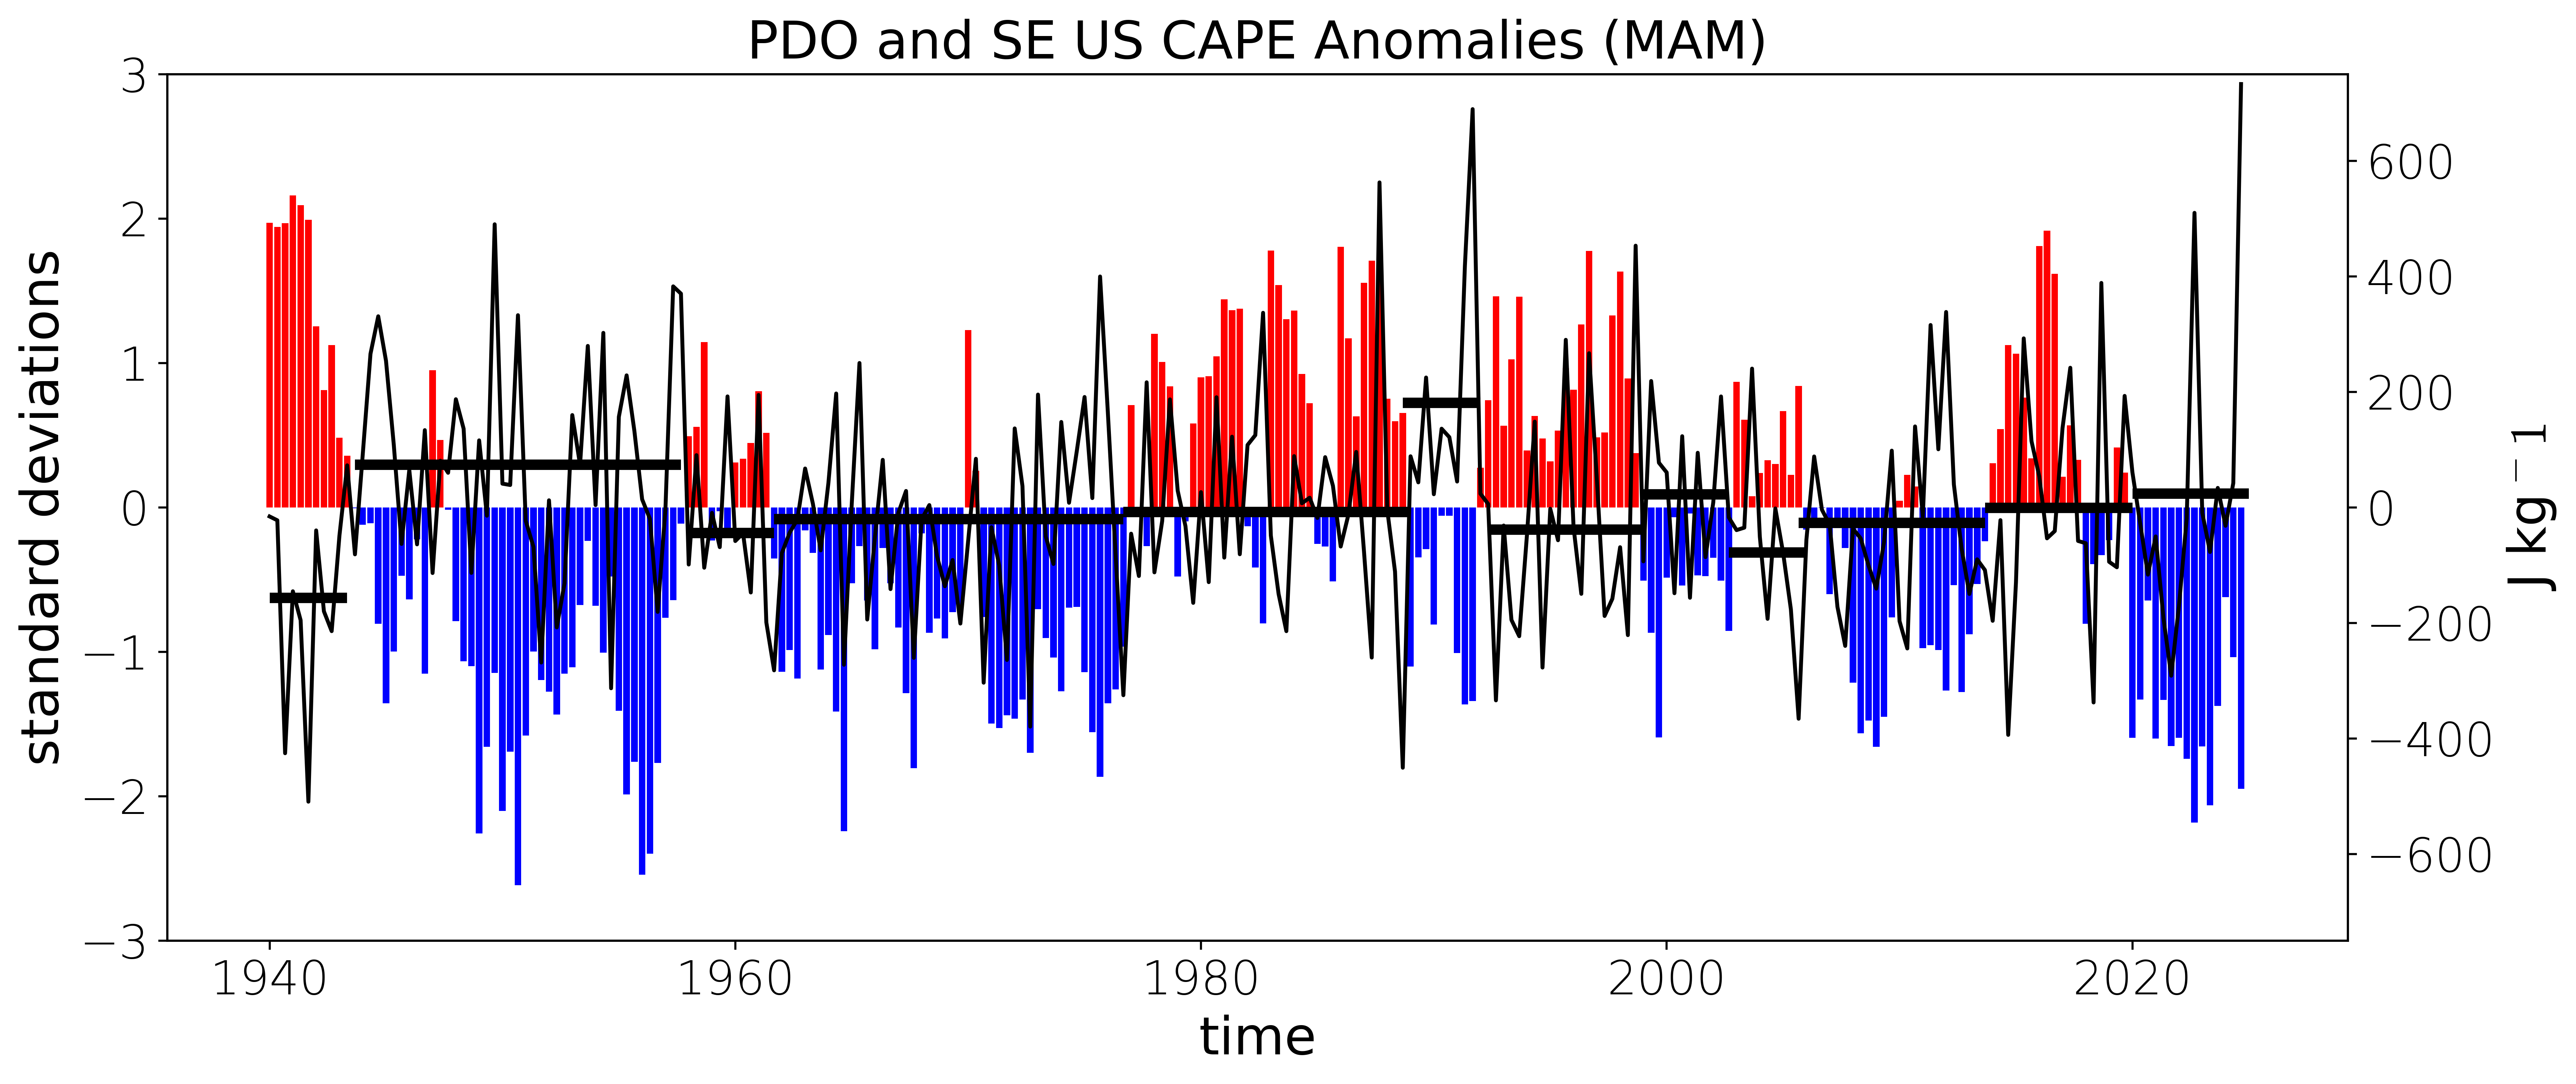

In [162]:
fig, ax = plt.subplots(figsize=(15, 6))

colors = ['red' if v >= 0 else 'blue' for v in pdo_1940_2024_mam]

years = np.arange(1940, 2025, 1/3)

ax.bar(years, pdo_1940_2024_mam, color=colors, width=0.28)
ax.set_ylim(-3, 3)
ax.set_ylabel('standard deviations', fontsize=20)

ax2 = ax.twinx()
ax2.plot(years, poly_detrend_no_climo_mean, color='black')
ax2.set_ylim(-750, 750)
ax2.set_ylabel('J kg${^-1}$', fontsize=20)

ax.set_xlabel('time', fontsize=20)
ax.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

ax2.hlines(poly_detrend_no_climo_mean[0:11].mean(), xmin=1940, xmax=1940+(10/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[11:54].mean(), xmin=1940+(11/3), xmax=1940+(53/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[54:66].mean(), xmin=1940+(54/3), xmax=1940+(65/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[66:110].mean(), xmin=1940+(65/3), xmax=1940+(110/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[110:147].mean(), xmin=1940+(110/3), xmax=1940+(147/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[147:157].mean(), xmin=1940+(146/3), xmax=1940+(156/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[157:177].mean(), xmin=1940+(157/3), xmax=1940+(177/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[177:189].mean(), xmin=1940+(177/3), xmax=1940+(188/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[189:198].mean(), xmin=1940+(188/3), xmax=1940+(198/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[198:222].mean(), xmin=1940+(197/3), xmax=1940+(221/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[222:241].mean(), xmin=1940+(221/3), xmax=1940+(240/3), lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean[241:].mean(), xmin=1940+(240/3), xmax=1940+(255/3), lw=4, color='black')

ax.set_title('PDO and SE US CAPE Anomalies (MAM)', fontsize=20)

Text(0.5, 1.0, 'PDO and SE US CAPE Anomalies (MAM)')

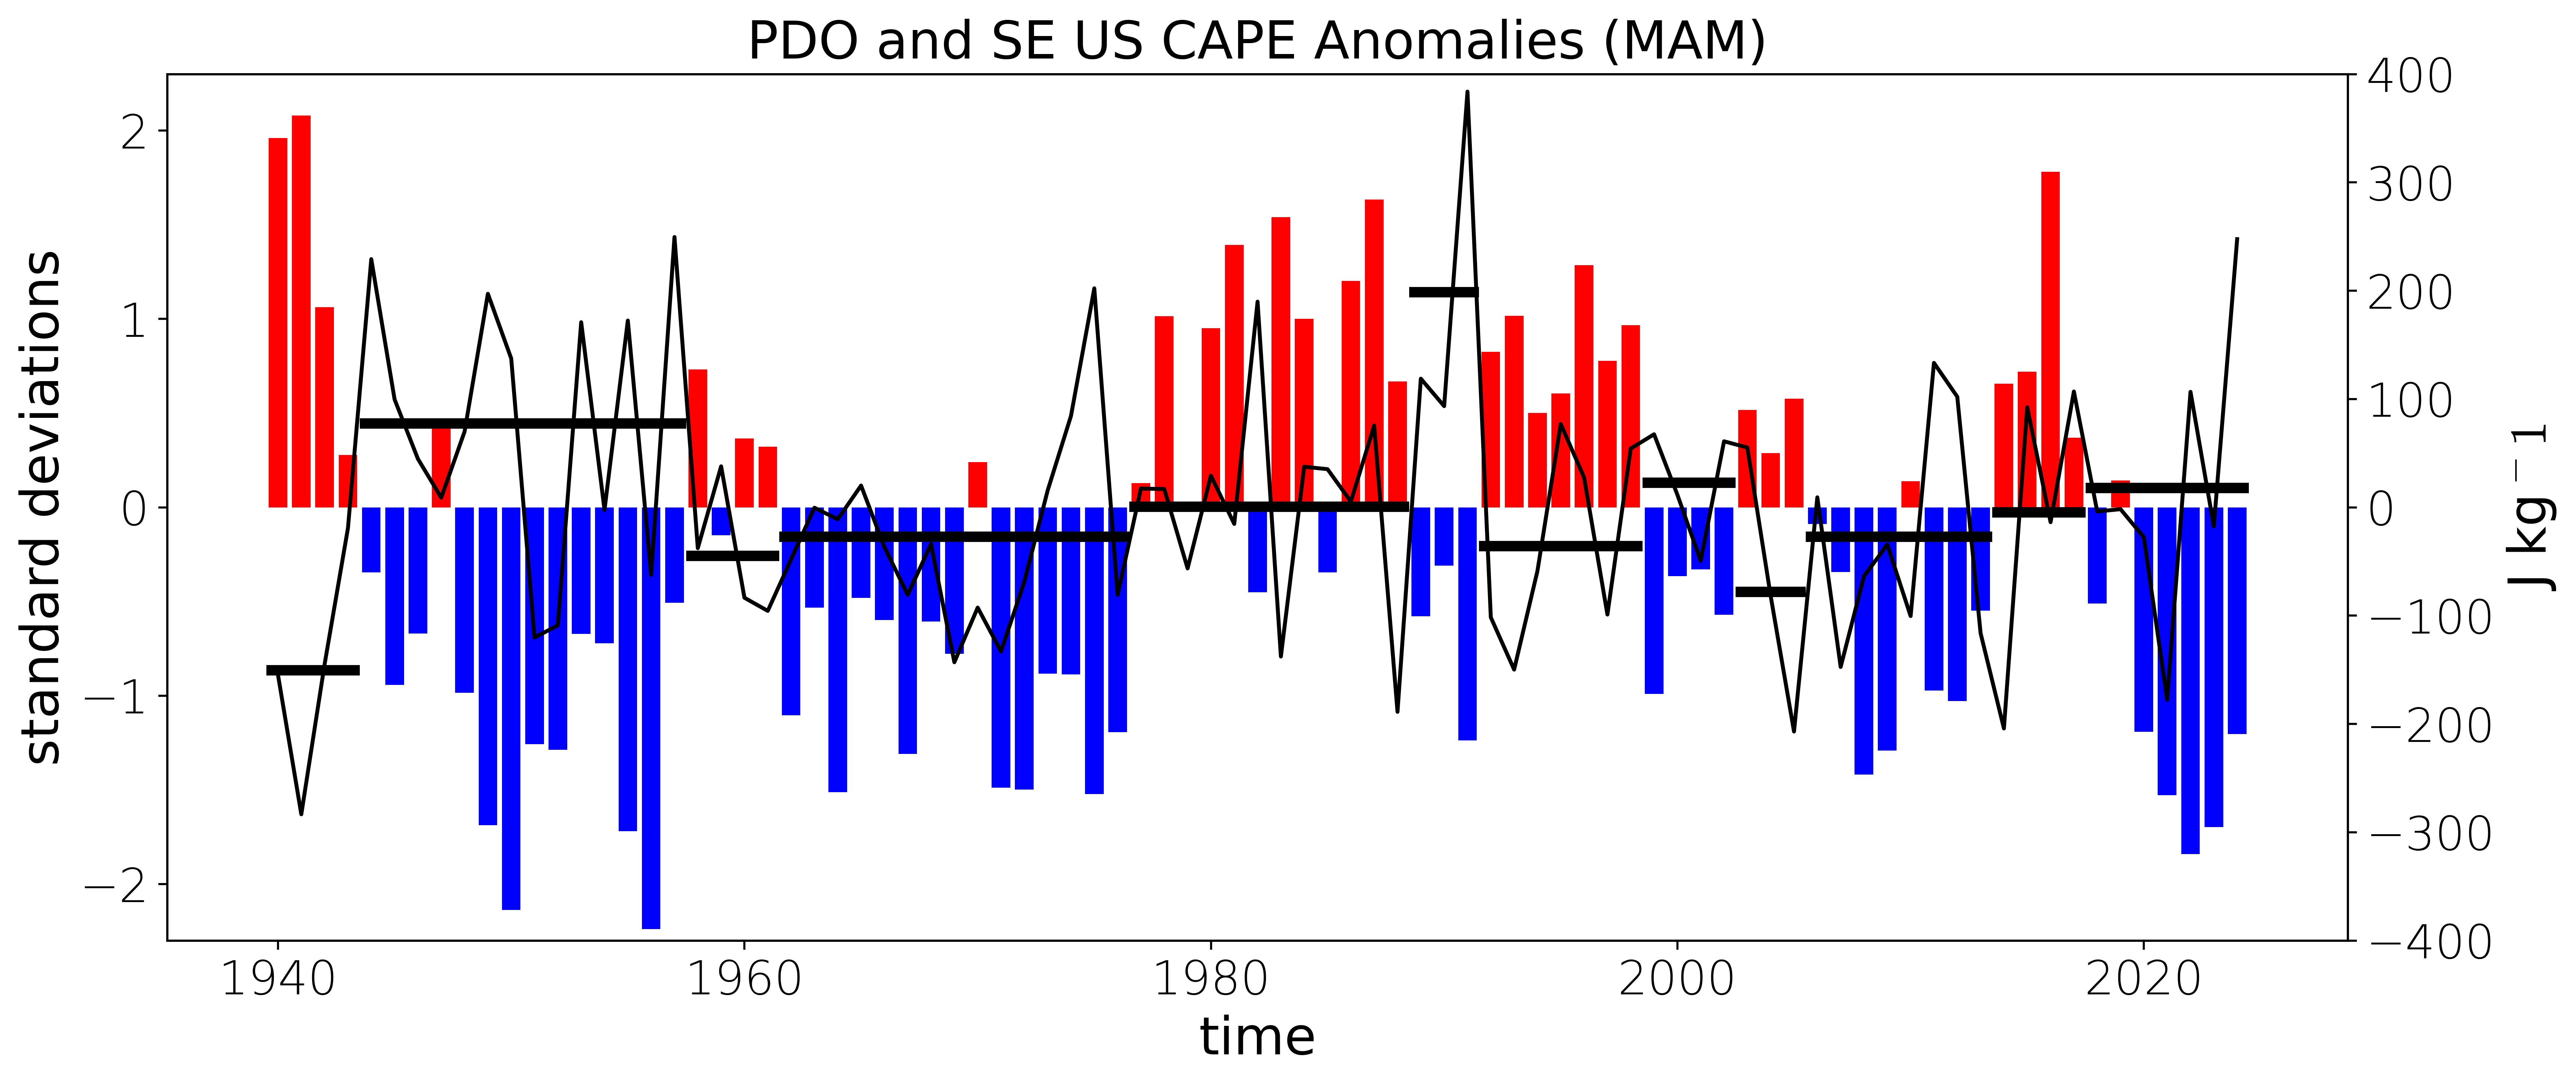

In [201]:
fig, ax = plt.subplots(figsize=(15, 6))

colors = ['red' if v >= 0 else 'blue' for v in pdo_1940_2024_mam.groupby('time.year').mean()]

years = np.arange(1940, 2025, 1)

ax.bar(years, pdo_1940_2024_mam.groupby('time.year').mean(), color=colors, width=0.8)
ax.set_ylim(-2.3, 2.3)
ax.set_ylabel('standard deviations', fontsize=20)

ax2 = ax.twinx()
ax2.plot(years, poly_detrend_no_climo_mean.groupby('time.year').mean(), color='black')
ax2.set_ylim(-400, 400)
ax2.set_ylabel('J kg${^-1}$', fontsize=20)

ax.set_xlabel('time', fontsize=20)
ax.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[0:4].mean(), xmin=1939.5, xmax=1940+3.5, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[4:18].mean(), xmin=1943.5, xmax=1943.5+14, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[18:22].mean(), xmin=1957.5, xmax=1957.5+4, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[22:37].mean(), xmin=1961.5, xmax=1961.5+15, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[37:49].mean(), xmin=1976.5, xmax=1976.5+12, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[49:52].mean(), xmin=1988.5, xmax=1988.5+3, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[52:59].mean(), xmin=1991.5, xmax=1991.5+7, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[59:63].mean(), xmin=1998.5, xmax=1998.5+4, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[63:66].mean(), xmin=2002.5, xmax=2002.5+3, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[66:74].mean(), xmin=2005.5, xmax=2005.5+8, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[74:78].mean(), xmin=2013.5, xmax=2013.5+4, lw=4, color='black')
ax2.hlines(poly_detrend_no_climo_mean.groupby('time.year').mean()[78:].mean(), xmin=2017.5, xmax=2017.5+7, lw=4, color='black')

ax.set_title('PDO and SE US CAPE Anomalies (MAM)', fontsize=20)